### Question #1

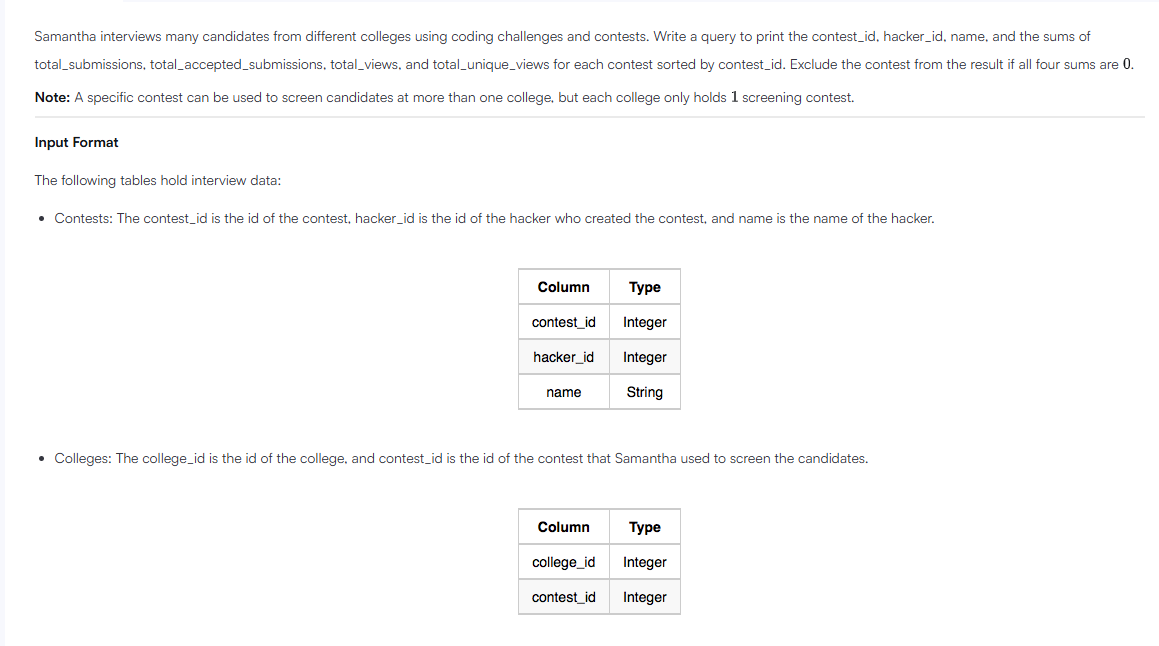
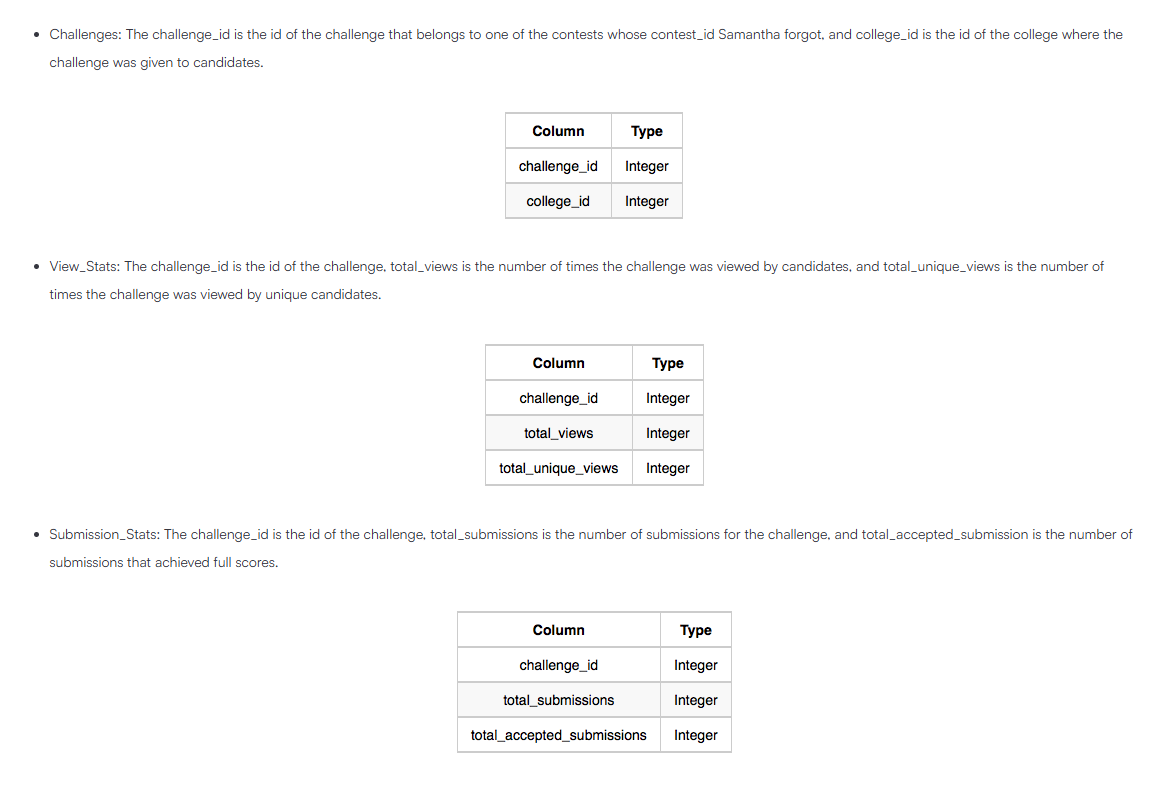
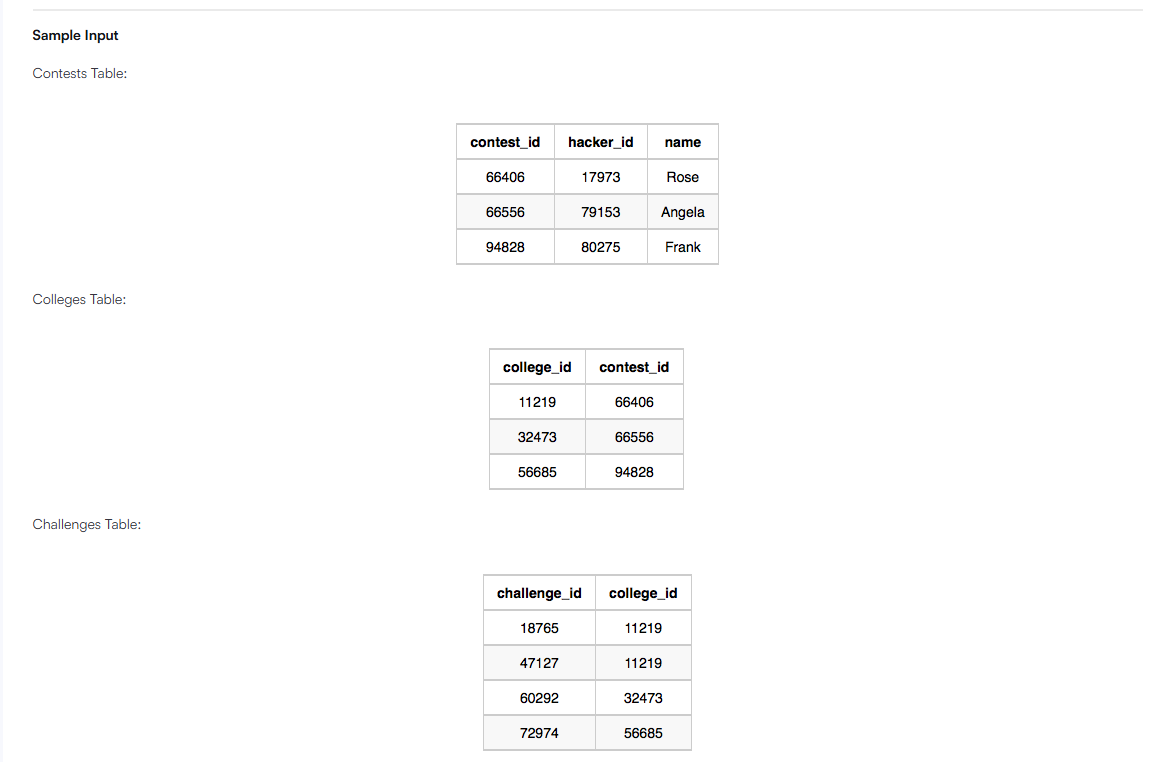
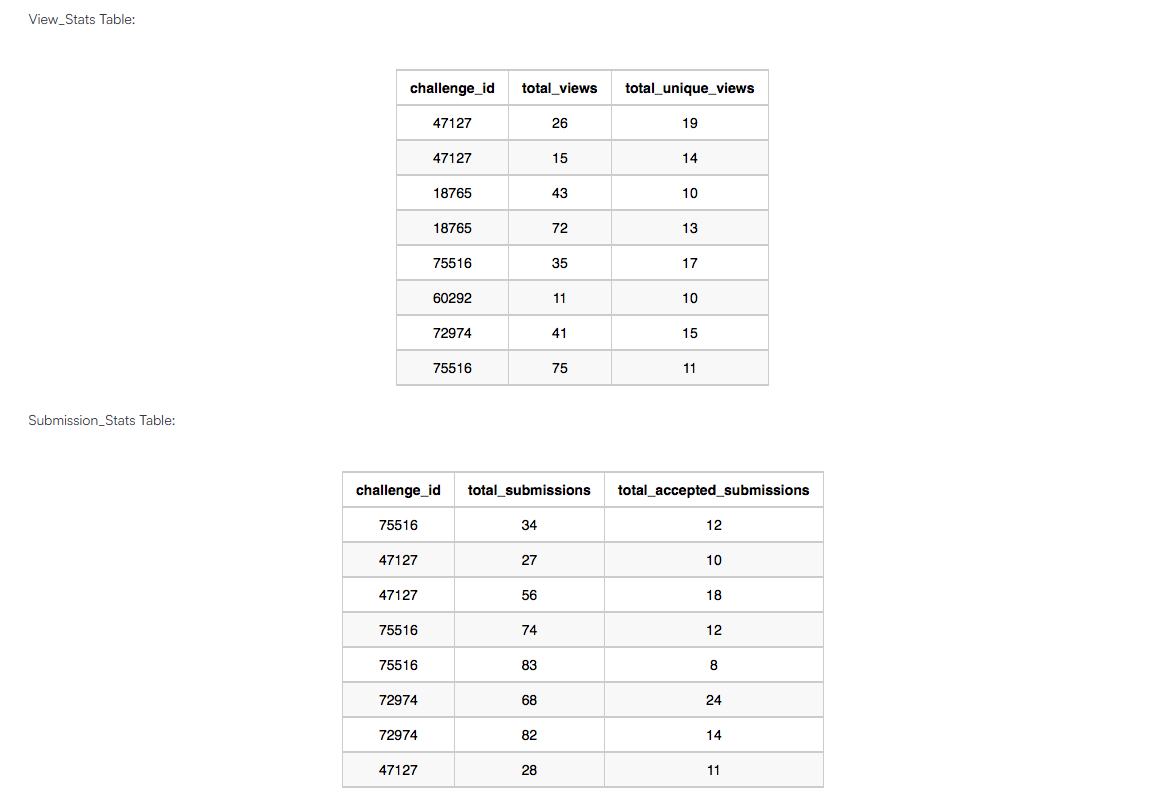
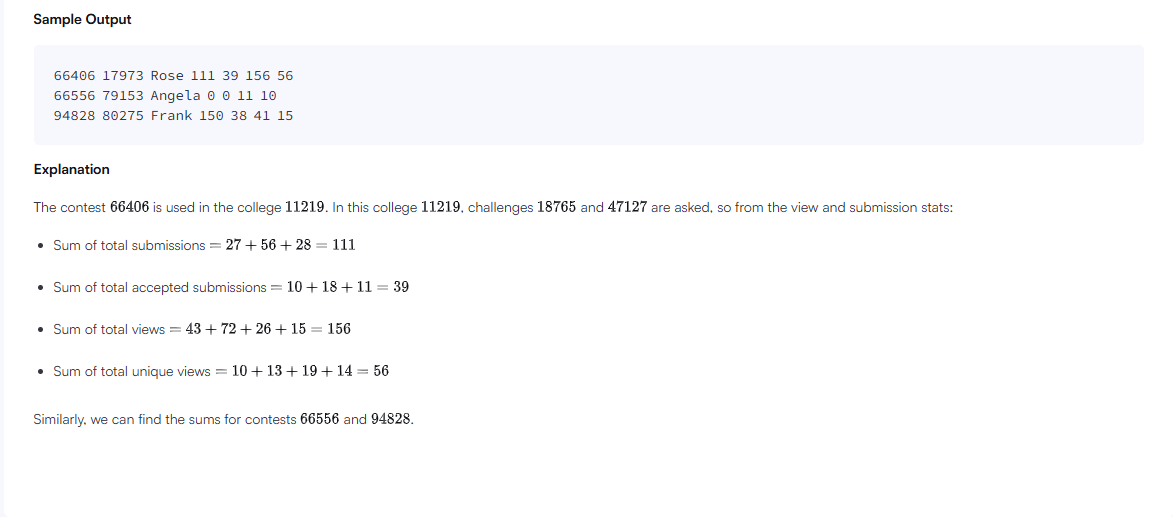

### Solution

In [0]:
## Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col, sum


In [0]:
## Import pyspark object
## Pyspark session is initialize by default when the notebook is attached to the cluster
spark = SparkSession.builder.appName("HackerRank SQL").getOrCreate()

In [0]:
## Create schemas
contests_schema = StructType([StructField('contest_id', IntegerType(), False ),
                             StructField('hacker_id', IntegerType(), False),
                             StructField('name', StringType(), False)]
                            )

colleges_schema = StructType([StructField('college_id', IntegerType(), False),
                             StructField('contest_id', IntegerType(), False)]
                            )
     
challenges_schema = StructType([StructField('challenge_id', IntegerType(), False),
                               StructField('college_id', IntegerType(), False)])         

views_schema = StructType([StructField('challenge_id', IntegerType(), False),
                           StructField('total_views', IntegerType(), False),
                           StructField('total_unique_views', IntegerType(), False)])             

submissions_schema = StructType([StructField('challenge_id', IntegerType(), False),
                                StructField('total_submissions', IntegerType(), False),
                                StructField('total_accepted_submissions', IntegerType(), False)])                                                                                  

In [0]:
# Create folder
# dbutils.fs.mkdirs('/FileStore/HackerRank')
# dbutils.fs.rm('dbfs:/FileStore/HackerRank/View_Stats-1.csv', True)
dbutils.fs.ls('/FileStore/HackerRank')

Out[4]: [FileInfo(path='dbfs:/FileStore/HackerRank/Challenges.csv', name='Challenges.csv', size=12481, modificationTime=1730586225000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Colleges.csv', name='Colleges.csv', size=6350, modificationTime=1730585150000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Contests.csv', name='Contests.csv', size=4913, modificationTime=1730585150000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Submission_Stats.csv', name='Submission_Stats.csv', size=25410, modificationTime=1730586225000),
 FileInfo(path='dbfs:/FileStore/HackerRank/View_Stats.csv', name='View_Stats.csv', size=25384, modificationTime=1730586846000)]

In [0]:
## Create dataframe from input CSV
contests_df = spark.read.csv('dbfs:/FileStore/HackerRank/Contests.csv', schema=contests_schema, header=True)
colleges_df = spark.read.csv('dbfs:/FileStore/HackerRank/Colleges.csv', schema=colleges_schema, header=True)
challenges_df = spark.read.csv('dbfs:/FileStore/HackerRank/Challenges.csv', schema=challenges_schema, header=True)
views_df = spark.read.csv('dbfs:/FileStore/HackerRank/View_Stats.csv', schema=views_schema, header=True)
submissions_df = spark.read.csv('dbfs:/FileStore/HackerRank/Submission_Stats.csv', schema=submissions_schema, header=True)

In [0]:
## Create pyspark views
contests_df.createOrReplaceTempView('contests')
colleges_df.createOrReplaceTempView('colleges')
challenges_df.createOrReplaceTempView('challenges')
views_df.createOrReplaceTempView('view_stats')
submissions_df.createOrReplaceTempView('submission_stats')


###SQL Solution

In [0]:
%sql
select co.contest_id, co.hacker_id, co.name,  
  sum(total_submissions) as total_submissions, 
  sum(total_accepted_submissions) total_accepted_submissions, 
  sum(total_views) as total_views,  
  sum(total_unique_views) as total_unique_views
from contests co 
join colleges cl on co.contest_id = cl.contest_id
join challenges ch on cl.college_id = ch.college_id
left outer join (
  select challenge_id, sum(total_submissions) as total_submissions, sum(total_accepted_submissions) as total_accepted_submissions
   from submission_stats group by challenge_id
          ) ss on ch.challenge_id = ss.challenge_id
left outer join (
  select challenge_id, sum(total_views) as total_views, sum(total_unique_views) as total_unique_views
    from view_stats group by challenge_id
          ) vs on ch.challenge_id = vs.challenge_id
group by co.contest_id, co.hacker_id, co.name 
order by co.contest_id
limit 10

contest_id,hacker_id,name,total_submissions,total_accepted_submissions,total_views,total_unique_views
845,579,Rose,1987,580,1635,566
858,1053,Angela,703,160,1002,384
883,1055,Frank,1121,319,1217,338
1793,2655,Patrick,1337,360,1216,412
2374,2765,Lisa,2733,815,3368,904
2963,2845,Kimberly,4306,1221,3603,1184
3584,2873,Bonnie,2492,652,3019,954
4044,3067,Michael,1323,449,1722,528
4249,3116,Todd,1452,376,1767,463
4269,3256,Joe,1018,372,1766,530


###Pyspark solution

In [0]:
## 1. Create aggregated results of submittion and view dataset

# submission_stats dataframe
submission_stats_df = submissions_df.groupby(col('challenge_id')).agg(sum(col('total_submissions')).alias('total_submissions'),
                                                                      sum(col('total_accepted_submissions')).alias('total_accepted_submissions'))
# submission_stats dataframe
view_stats_df = views_df.groupby(col('challenge_id')).agg(sum(col('total_views')).alias('total_views'),
                                                          sum(col('total_unique_views')).alias('total_unique_views'))
display(view_stats_df.limit(10))

challenge_id,total_views,total_unique_views
59384,239,73
80579,124,33
9465,169,23
15447,149,44
99454,16,10
65771,138,42
18956,169,25
29827,259,45
27261,123,34
59748,32,7


In [0]:
## 2. Join all the datasets
combined_df = contests_df.join(colleges_df,['contest_id'], how='inner')\
    .join(challenges_df, ['college_id'], how='inner')\
        .join(submission_stats_df, ['challenge_id'], how='outer')\
            .join(view_stats_df, ['challenge_id'], how='outer')

display(combined_df.limit(10))

challenge_id,college_id,contest_id,hacker_id,name,total_submissions,total_accepted_submissions,total_views,total_unique_views
97,96,845,579,Rose,117,32,null,null
145,96,845,579,Rose,38,17,170,52
276,96,845,579,Rose,57,30,72,41
345,96,845,579,Rose,139,39,null,null
492,96,845,579,Rose,null,null,124,42
558,96,845,579,Rose,270,61,null,null
773,96,845,579,Rose,90,36,301,75
791,96,845,579,Rose,207,55,22,22
829,96,845,579,Rose,121,31,186,59
868,96,845,579,Rose,81,6,null,null


In [0]:
## 3. Aggregate all dataset to get the final result
final_df = combined_df.groupby(col('contest_id'), col('hacker_id'), col('name'))\
    .agg(sum(col('total_submissions')).alias('total_submissions'),\
        sum(col('total_accepted_submissions')).alias('total_accepted_submissions'),\
            sum(col('total_views')).alias('total_views'),\
                sum(col('total_unique_views')).alias('total_unique_views')
        ).orderBy(col('contest_id'))
display(final_df.limit(10)) 

contest_id,hacker_id,name,total_submissions,total_accepted_submissions,total_views,total_unique_views
845,579,Rose,1987,580,1635,566
858,1053,Angela,703,160,1002,384
883,1055,Frank,1121,319,1217,338
1793,2655,Patrick,1337,360,1216,412
2374,2765,Lisa,2733,815,3368,904
2963,2845,Kimberly,4306,1221,3603,1184
3584,2873,Bonnie,2492,652,3019,954
4044,3067,Michael,1323,449,1722,528
4249,3116,Todd,1452,376,1767,463
4269,3256,Joe,1018,372,1766,530
